Task: Predict whether a user will vote on another user's posting

**Considered datasets:**
* Network of Users Who Vote on Postings (undirected) - df_edge_list_undirected_users_votes_to_postings_net
* Network on Posting Behaviour of Users (undirected) - df_edge_list_undirected_users_postings_to_same_articles
* Network of Users Who Reply to Postings (directed) - df_edge_list_directed_users_postings_replies

**Additional datasets:**
* df_Postings_filtered_net - Probably would need this as well since we can filter out posting by their date
* df_Votes_filtered_net 

In [143]:
import node2vec
from node2vec import Node2Vec
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from linkpred import LinkPred
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import numpy as np
import random
#maybe this one is better but don't import both Node2Vec at the same time!
#from torch_geometric.nn import Node2Vec 

In [6]:
folder_path = "./data"

In [7]:
# Directory containing your Parquet files
relative_path_to_data = folder_path
data_directory = os.path.abspath(relative_path_to_data)

# Desired file stems to load
desired_files = {
    "df_edge_list_undirected_users_votes_to_postings_net",
    "df_edge_list_undirected_users_postings_to_same_articles",
    "df_edge_list_directed_users_postings_replies",
    "df_Postings_filtered_net",
    "df_Votes_filtered_net"
}

# Dictionary to store DataFrames with stem names as keys
dataframes = {}

# Iterate over all Parquet files in the directory
for file_path in Path(data_directory).glob("*.parquet"):

    # Extract the file stem (name without extension)
    file_stem = file_path.stem
    
    # Check if the file stem is in the desired list
    if file_stem in desired_files:
        print(f"Reading file: {file_stem}")
        
        # Read the Parquet file into a DataFrame
        df = pd.read_parquet(file_path)
        
        # Store the DataFrame in the dictionary with the stem as the key
        dataframes[file_stem] = df

# Access DataFrames by their file stem
print(f"Loaded DataFrames: {list(dataframes.keys())}")

Reading file: df_edge_list_undirected_users_postings_to_same_articles
Reading file: df_edge_list_undirected_users_votes_to_postings_net
Reading file: df_Postings_filtered_net
Reading file: df_edge_list_directed_users_postings_replies
Reading file: df_Votes_filtered_net
Loaded DataFrames: ['df_edge_list_undirected_users_postings_to_same_articles', 'df_edge_list_undirected_users_votes_to_postings_net', 'df_Postings_filtered_net', 'df_edge_list_directed_users_postings_replies', 'df_Votes_filtered_net']


In [8]:
# Assign relevant DataFrames to new variable names
votes_to_postings = dataframes["df_edge_list_undirected_users_votes_to_postings_net"]
postings_to_articles = dataframes["df_edge_list_undirected_users_postings_to_same_articles"]
replies = dataframes["df_edge_list_directed_users_postings_replies"]

# Additional datasets
filtered_postings = dataframes["df_Postings_filtered_net"]
filtered_votes = dataframes["df_Votes_filtered_net"]

# Verify the updated key names in the dictionary
print("Updated DataFrame keys:", list(dataframes.keys()))

# Example access
print(votes_to_postings.head())  # View the first few rows of one of the DataFrames

Updated DataFrame keys: ['df_edge_list_undirected_users_postings_to_same_articles', 'df_edge_list_undirected_users_votes_to_postings_net', 'df_Postings_filtered_net', 'df_edge_list_directed_users_postings_replies', 'df_Votes_filtered_net']
   ID_CommunityIdentity_min  ID_CommunityIdentity_max  \
0                         4                      6293   
1                         4                      8008   
2                         4                      9525   
3                         4                     18764   
4                         4                     21088   

   count_votes_to_postings_net  
0                            1  
1                            1  
2                            1  
3                            1  
4                            1  


We decided to experiment with the following dataframes for link prediction:
- "df_edge_list_undirected_users_votes_to_postings_net"

In [9]:
print("Undirected Votes DataFrame Info:")
print(votes_to_postings.info(), "\n")

Undirected Votes DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5535637 entries, 0 to 5535636
Data columns (total 3 columns):
 #   Column                       Dtype
---  ------                       -----
 0   ID_CommunityIdentity_min     int64
 1   ID_CommunityIdentity_max     int64
 2   count_votes_to_postings_net  int64
dtypes: int64(3)
memory usage: 126.7 MB
None 



In [10]:
print("Missing Data in Undirected Replies:")
print(votes_to_postings.isnull().sum(), "\n")

Missing Data in Undirected Replies:
ID_CommunityIdentity_min       0
ID_CommunityIdentity_max       0
count_votes_to_postings_net    0
dtype: int64 



In [11]:
print("\nPreview of DataFrame:")
display(votes_to_postings.head())


Preview of DataFrame:


,ID_CommunityIdentity_min,ID_CommunityIdentity_max,count_votes_to_postings_net
0,4,6293,1
1,4,8008,1
2,4,9525,1
3,4,18764,1
4,4,21088,1


### Link Prediction

First we experiment with the directed version

In [12]:
# Convert the undirected votes dataset into a graph
G_undirected = nx.from_pandas_edgelist(
    votes_to_postings,  # Replace with your DataFrame variable
    source="ID_CommunityIdentity_min",
    target="ID_CommunityIdentity_max",
    edge_attr="count_votes_to_postings_net",  # Optional: edge weights
    create_using=nx.Graph()  # Ensure an undirected graph
)


In [13]:
# check if its directed
G_undirected.is_directed()


False

In [14]:
# create subgraph

# Sample a smaller subgraph
subgraph = G_undirected.subgraph(list(G_undirected.nodes)[:1000])  # Adjust size 

# G_directed = subgraph # comment it out when using the full graph


In [15]:
#check number of nodes
subgraph.number_of_nodes()

1000

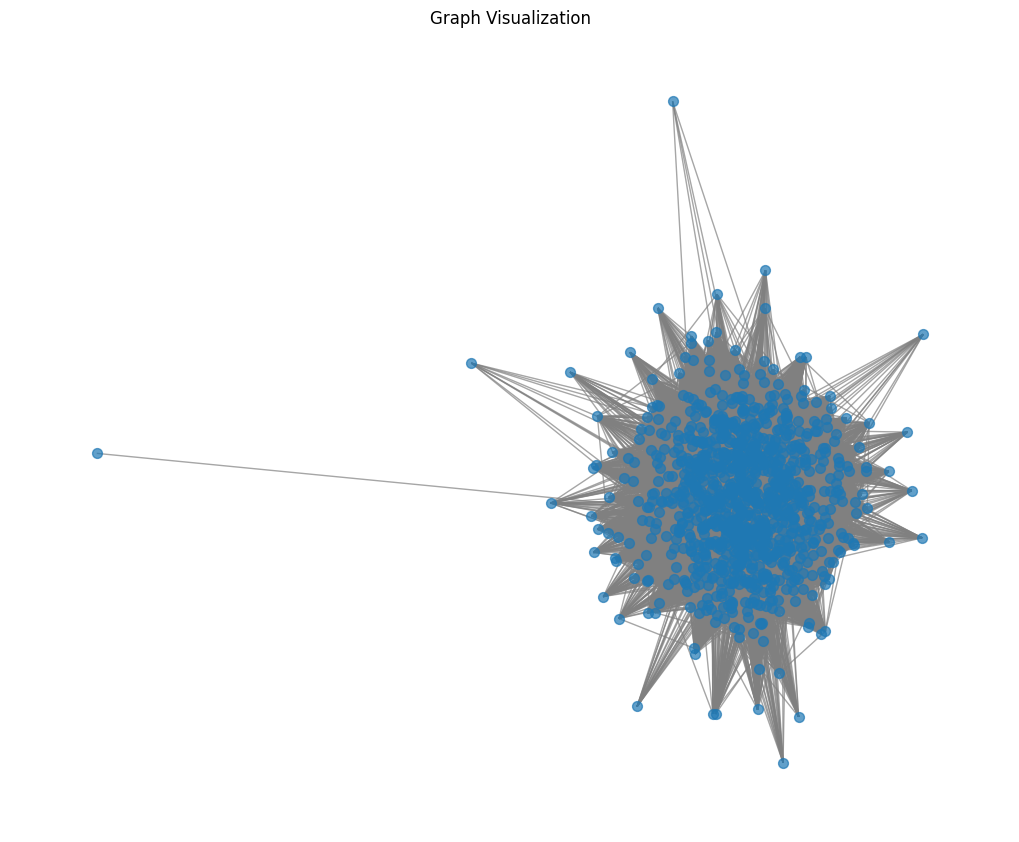

In [16]:
# Visualize the subgraph with basic layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph) 
nx.draw(
    subgraph, 
    pos, 
    with_labels=False, 
    node_size=50, 
    edge_color='gray', 
    alpha=0.7
)
plt.title("Graph Visualization")
plt.show()

### Train Test and Validation Split

In [51]:
graph = subgraph # comment it out when using the full
# graph = G_undirected # comment it out when using the subgraph

In [69]:
len(graph.edges)

191829

In [121]:
# 1. Extract all edges (positive examples)
edges = list(graph.edges())

# 2. Split edges into train/test (85% train+val, 15% test)
train_val_edges, test_edges = train_test_split(edges, test_size=0.15, random_state=42)

# 3. Split train_val into train (70%) and validation (15%)
train_edges, val_edges = train_test_split(train_val_edges, test_size=0.1765, random_state=42)  # 0.1765 ≈ 15% of 85%

# 4. Create the train graph (only training edges)
graph_train = graph.copy()
graph_train.remove_edges_from(val_edges)
graph_train.remove_edges_from(test_edges)

# Ensure all nodes from the original graph are in the train graph
graph_train.add_nodes_from(graph.nodes())

# Print statistics
print(f"Original Graph: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")
print(f"Train Graph: {graph_train.number_of_nodes()} nodes, {graph_train.number_of_edges()} edges")
print(f"Training Edges: {len(train_edges)}")
print(f"Validation Edges: {len(val_edges)}")
print(f"Test Edges: {len(test_edges)}")

Original Graph: 1000 nodes, 191829 edges
Train Graph: 1000 nodes, 134274 edges
Training Edges: 134274
Validation Edges: 28780
Test Edges: 28775


In [122]:
# Generate negative edges (non-edges)
all_non_edges = set(nx.non_edges(graph))

# Sample negative edges for each set
train_neg_edges = random.sample(all_non_edges, len(train_edges))
val_neg_edges = random.sample(all_non_edges - set(train_neg_edges), len(val_edges))
test_neg_edges = random.sample(all_non_edges - set(train_neg_edges) - set(val_neg_edges), len(test_edges))

# Verify counts
print(f"Train Negative Edges: {len(train_neg_edges)}")
print(f"Validation Negative Edges: {len(val_neg_edges)}")
print(f"Test Negative Edges: {len(test_neg_edges)}")

Train Negative Edges: 134274
Validation Negative Edges: 28780
Test Negative Edges: 28775


/var/folders/h0/ypxj_t612537gn89tkfhrb_00000gn/T/ipykernel_48888/1683674122.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_neg_edges = random.sample(all_non_edges, len(train_edges))
/var/folders/h0/ypxj_t612537gn89tkfhrb_00000gn/T/ipykernel_48888/1683674122.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_neg_edges = random.sample(all_non_edges - set(train_neg_edges), len(val_edges))
/var/folders/h0/ypxj_t612537gn89tkfhrb_00000gn/T/ipykernel_48888/1683674122.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_neg_edges = random.sample(all_non_edges - set(train_neg_edges) - set(val_neg_edges), len(test_edges))


### Train and evaluate link prediction model using node2vec

In [123]:
# Calculate node embeddings with Node2Vec on the training graph

node2vec_train = Node2Vec(
    graph=graph_train, # Use the training graph
    dimensions=64,    # Embedding dimensions
    walk_length=30,   # Length of random walks
    num_walks=200,    # Number of random walks per node
    workers=4         # Parallel threads
)

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


In [124]:
# Fit the model and extract embeddings
model_train = node2vec_train.fit()
embeddings_train = {node: model_train.wv[str(node)] for node in graph_train.nodes()}

# Verify embeddings
print(f"Number of nodes in train_graph: {graph_train.number_of_nodes()}")
print(f"Number of generated embeddings: {len(embeddings_train)}")

Number of nodes in train_graph: 1000
Number of generated embeddings: 1000


In [129]:
def embedding_train(node):
    return model_train.wv[str(node)]

In [125]:
# verify embeddings
for node in list(graph_train.nodes())[:5]:
    print(f"Node {node}: {embeddings_train[node]}")

Node 163840: [ 0.6182747   0.0567262   0.00288938 -0.06088348  0.11967035 -0.126548
 -0.01545528  0.17566057 -0.13860135  0.07709353  0.03485776  0.05065428
 -0.18819577 -0.3802606  -0.0199722   0.25501147  0.12575375  0.04279836
  0.22625357  0.12510104 -0.1185234   0.16241997 -0.21971054 -0.5622828
 -0.06074624 -0.1722541   0.25268427  0.04522743  0.06610001  0.14743158
 -0.23062585  0.0335392   0.2318456  -0.552645   -0.233267    0.29021797
 -0.18429846 -0.00692332 -0.16591902  0.40505072 -0.2221133  -0.2694298
 -0.10193023  0.02756348  0.36846438 -0.05165431 -0.00166494 -0.30009773
  0.05849851 -0.17571357 -0.09053525 -0.10064899  0.40627322 -0.1967606
  0.08483703 -0.10531159 -0.22130261  0.05171081 -0.21352583  0.02095296
 -0.18778308  0.21324512 -0.04957148  0.21451297]
Node 522241: [-3.17577980e-02  1.93269506e-01  7.73843080e-02  3.77538651e-01
  2.53016889e-01  2.40282547e-02 -3.63848247e-02  8.69543571e-03
  9.20800567e-02  1.49080113e-01  4.88608144e-02 -2.73083001e-01
  2.

In [131]:
# Define binary operators
def operator_hadamard(u, v):
    return u * v  # Element-wise product

def operator_l1(u, v):
    return np.abs(u - v)  # L1 distance

def operator_l2(u, v):
    return (u - v) ** 2  # L2 distance

def operator_avg(u, v):
    return (u + v) / 2  # Average

# List of operators
binary_operators = {
    "Hadamard": operator_hadamard,
    "L1": operator_l1,
    "L2": operator_l2,
    "Average": operator_avg
}

In [132]:
# Generate features for positive training edges
X_train_pos = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in train_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Generate features for negative training edges
X_train_neg = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in train_neg_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Combine features
X_train = np.vstack([X_train_pos, X_train_neg])  # Combine positive and negative features
y_train = [1] * len(X_train_pos) + [0] * len(X_train_neg)  # Labels: 1 for positive, 0 for negative

# Verify outputs
print(f"Train Features: {len(X_train)}, Positive Edges: {len(X_train_pos)}, Negative Edges: {len(X_train_neg)}")

Train Features: 268548, Positive Edges: 134274, Negative Edges: 134274


In [133]:
# Generate features for positive validation edges
X_val_pos = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in val_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Generate features for negative validation edges
X_val_neg = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in val_neg_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Combine features
X_val = np.vstack([X_val_pos, X_val_neg])  # Combine positive and negative features
y_val = [1] * len(X_val_pos) + [0] * len(X_val_neg)  # Labels: 1 for positive, 0 for negative

# Verify outputs
print(f"Validation Features: {len(X_val)}, Positive Edges: {len(X_val_pos)}, Negative Edges: {len(X_val_neg)}")

Validation Features: 57560, Positive Edges: 28780, Negative Edges: 28780


In [134]:
# Train the logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [135]:
# Predict probabilities for the validation set
y_val_proba = clf.predict_proba(X_val)[:, 1]  # Probability of the positive class (1)

# Compute ROC AUC
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation ROC AUC: {val_auc:.4f}")

Validation ROC AUC: 0.6606


### Evaluate the best model using the test set 

In [136]:
# Train Node2Vec on the test graph
node2vec_test = Node2Vec(
    graph_test,  # Use the test graph
    dimensions=64,
    walk_length=30,
    num_walks=200,
    workers=4
)

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


In [137]:
model_test = node2vec_test.fit()

# Create a function to retrieve test embeddings
def embedding_test(node):
    return model_test.wv[str(node)]

In [138]:
# Generate features for test edges (positive and negative)
X_test_pos = [operator_avg(embedding_test(u), embedding_test(v)) for u, v in test_edges]
X_test_neg = [operator_avg(embedding_test(u), embedding_test(v)) for u, v in test_neg_edges]

# Combine features and labels
X_test = np.vstack([X_test_pos, X_test_neg])
y_test = [1] * len(test_edges) + [0] * len(test_neg_edges)

In [139]:
# Predict probabilities and labels for the test set
y_test_proba = clf.predict_proba(X_test)[:, 1]
y_test_pred = clf.predict(X_test)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.4699
Test ROC AUC: 0.4179


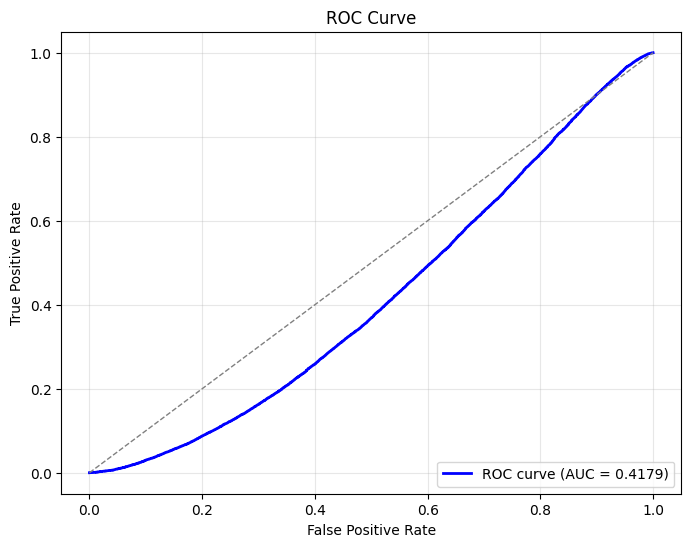

In [145]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Tune Node2vec

In [144]:
from itertools import product

# Define the parameter grid
dimensions_list = [32, 64, 128]
walk_length_list = [10, 20, 30]
num_walks_list = [10, 20, 50]
p_list = [0.5, 1, 2]
q_list = [0.5, 1, 2]

# Iterate over all parameter combinations
best_auc = 0
best_params = None

for dimensions, walk_length, num_walks, p, q in product(dimensions_list, walk_length_list, num_walks_list, p_list, q_list):
    print(f"Testing parameters: dimensions={dimensions}, walk_length={walk_length}, num_walks={num_walks}, p={p}, q={q}")
    
    # Train Node2Vec with current parameters
    node2vec = Node2Vec(
        graph=graph_train,
        dimensions=dimensions,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=4,
        p=p,
        q=q
    )
    model = node2vec.fit()
    
    # Generate embeddings
    embeddings = {node: model.wv[str(node)] for node in graph_train.nodes()}
    
    # Generate features for validation set
    X_val_pos = generate_features_with_operator(val_edges, lambda node: embeddings[str(node)], operator_hadamard)
    X_val_neg = generate_features_with_operator(val_neg_edges, lambda node: embeddings[str(node)], operator_hadamard)
    X_val = np.vstack([X_val_pos, X_val_neg])
    y_val = [1] * len(X_val_pos) + [0] * len(X_val_neg)
    
    # Train classifier on the train set
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    
    # Evaluate on the validation set
    y_val_proba = clf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_proba)
    print(f"Validation ROC AUC: {val_auc:.4f}")
    
    # Update the best parameters if current performance is better
    if val_auc > best_auc:
        best_auc = val_auc
        best_params = (dimensions, walk_length, num_walks, p, q)

print(f"\nBest Parameters: dimensions={best_params[0]}, walk_length={best_params[1]}, num_walks={best_params[2]}, p={best_params[3]}, q={best_params[4]}")
print(f"Best Validation ROC AUC: {best_auc:.4f}")


Testing parameters: dimensions=32, walk_length=10, num_walks=10, p=0.5, q=0.5


Computing transition probabilities:   2%|▏         | 22/1000 [00:04<02:59,  5.45it/s]


KeyboardInterrupt: 